In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv("y_2020.csv")

C:\Users\dingy\AppData\Local\Temp\ipykernel_4964\1465085523.py:1: DtypeWarning: Columns (1,2,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("y_2020.csv")


In [3]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198745 entries, 0 to 198744
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   C_YEAR  198745 non-null  int64 
 1   C_MNTH  198745 non-null  object
 2   C_WDAY  198745 non-null  object
 3   C_HOUR  198745 non-null  object
 4   C_SEV   198745 non-null  int64 
 5   C_VEHS  198745 non-null  object
 6   C_CONF  198745 non-null  object
 7   C_RCFG  198745 non-null  object
 8   C_WTHR  198745 non-null  object
 9   C_RSUR  198745 non-null  object
 10  C_RALN  198745 non-null  object
 11  C_TRAF  198745 non-null  object
 12  V_ID    198745 non-null  object
 13  V_TYPE  198745 non-null  object
 14  V_YEAR  198745 non-null  object
 15  P_ID    198745 non-null  object
 16  P_SEX   198745 non-null  object
 17  P_AGE   198745 non-null  object
 18  P_PSN   198745 non-null  object
 19  P_ISEV  198745 non-null  object
 20  P_SAFE  198745 non-null  object
 21  P_USER  198745 non-null  object
 

C_YEAR    0
V_ID      0
P_USER    0
P_SAFE    0
P_ISEV    0
P_PSN     0
P_AGE     0
P_SEX     0
P_ID      0
V_YEAR    0
V_TYPE    0
C_TRAF    0
C_MNTH    0
C_RALN    0
C_RSUR    0
C_WTHR    0
C_RCFG    0
C_CONF    0
C_VEHS    0
C_SEV     0
C_HOUR    0
C_WDAY    0
C_CASE    0
dtype: int64

In [4]:
# Drop ID and year columns
drop_cols = ['C_YEAR', 'V_ID', 'P_ID', 'C_CASE']
df = df.drop(columns=drop_cols, errors='ignore')

In [5]:
from sklearn.model_selection import train_test_split

y = df['P_ISEV']
X = df.drop(columns=['P_ISEV'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (119247, 18)
Validation size: (39749, 18)
Test size: (39749, 18)


In [6]:
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = ['V_YEAR'] 

def replace_fake_missing(df):
    df = df.copy()
    fake_missing_values = ['UU', 'XX', 'U', 'X', 'N', 'NN', 'QQ', 'UUUU', 'XXXX' '*', '**']
    df = df.replace(fake_missing_values, np.nan)
    return df

X_train = replace_fake_missing(X_train)
X_val = replace_fake_missing(X_val)
X_test = replace_fake_missing(X_test)

for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [7]:
X_train.head(20)

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER
167641,11,1,11,2,2,21,01,1,1,1,18,01,2018.0,M,51,23,02,2
139525,9,4,18,1,02,22,02,1,1,1,01,01,2005.0,F,66,11,02,1
174380,11,4,12,2,2,21,01,1,1,1,18,08,2013.0,M,63,11,02,1
160379,10,5,14,2,02,36,02,1,1,1,18,01,2019.0,nan,nan,11,nan,1
79036,6,2,08,2,1,34,02,1,1,2,02,nan,nan,M,68,99,nan,3
1839,1,1,09,2,01,06,01,1,3,1,18,01,2017.0,M,69,11,nan,1
154671,10,3,13,2,02,36,01,2,1,1,01,01,2001.0,M,38,11,02,1
7621,1,3,07,2,02,35,02,1,2,1,01,01,2017.0,F,24,11,02,1
165837,10,7,02,2,2,22,01,1,1,1,nan,nan,nan,nan,nan,11,nan,nan
187083,12,2,17,2,2,21,01,1,1,1,18,01,2020.0,M,34,11,02,1


In [8]:
fake_y_values = ['N', 'U', 'X']

y_train = y_train.replace(fake_y_values, np.nan)
y_val = y_val.replace(fake_y_values, np.nan)
y_test = y_test.replace(fake_y_values, np.nan)

X_train = X_train[y_train.notna()]
y_train = y_train[y_train.notna()]

X_val = X_val[y_val.notna()]
y_val = y_val[y_val.notna()]

X_test = X_test[y_test.notna()]
y_test = y_test[y_test.notna()]

In [9]:
y_train.head(20)

167641    1
139525    1
174380    1
160379    1
79036     2
1839      1
154671    2
7621      2
165837    1
187083    2
179379    1
57357     1
57804     1
81257     1
130956    2
64101     1
167232    2
73175     2
119317    2
180565    2
Name: P_ISEV, dtype: object

In [10]:
pseudo_numeric = ['P_AGE', 'P_PSN', 'C_VEHS']
numeric_cols += pseudo_numeric

all_object_cols = X_train.select_dtypes(include='object').columns.tolist()

categorical_cols = list(set(all_object_cols) - set(pseudo_numeric))

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

In [12]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        multi_class='multinomial',
        max_iter=1000
))
])

In [13]:
X_train_processed = preprocessor.fit_transform(X_train)

In [14]:
!pip install imbalanced-learn

In [15]:
from imblearn.over_sampling import SMOTE

# 初始化 SMOTE
smote = SMOTE(random_state=42)

# 拟合并生成平衡数据集
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

In [16]:
from sklearn.linear_model import LogisticRegression

model_smote = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000
)

model_smote.fit(X_resampled, y_resampled)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

              precision    recall  f1-score   support

           1       0.60      0.71      0.65     15266
           2       0.73      0.47      0.57     20853
           3       0.05      0.69      0.09       349

    accuracy                           0.57     36468
   macro avg       0.46      0.62      0.44     36468
weighted avg       0.67      0.57      0.60     36468



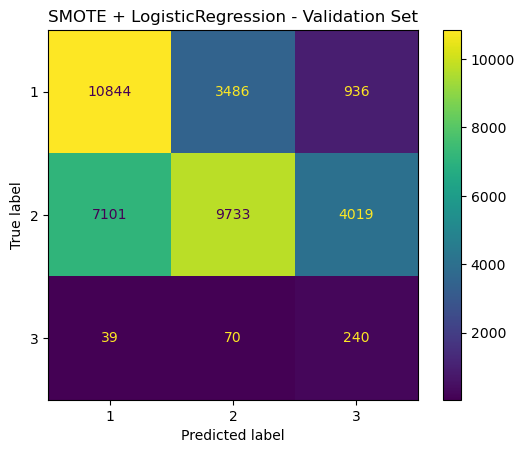

In [17]:
# 对验证集进行 transform（注意：只 transform，不要 fit）
X_val_processed = preprocessor.transform(X_val)

# 预测
y_val_pred = model_smote.predict(X_val_processed)

# 评估
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("SMOTE + LogisticRegression - Validation Set")
plt.show()

In [18]:
print("Train Accuracy:", model_smote.score(X_resampled, y_resampled))
print("Validation Accuracy:", model_smote.score(X_val_processed, y_val))

Train Accuracy: 0.669831678895123
Validation Accuracy: 0.5708292201382034
